In [2]:
import sframe                            # see below for install instruction

In [1]:
import matplotlib.pyplot as plt          # plotting
%matplotlib inline
import numpy as np                       # dense matrices

In [8]:
from scipy.sparse import csr_matrix      # sparse matrices
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from scipy.sparse.linalg import norm     # norms of sparse matrices
from copy import copy                                          # deep copies

In [84]:
import time

In [9]:
wiki = sframe.SFrame('people_wiki.gl/')
wiki = wiki.add_row_number()             # add row number, starting at 0

[INFO] sframe.cython.cy_server: SFrame v1.10 started. Logging /tmp/sframe_server_1467652791.log


In [10]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [12]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')
map_index_to_word = sframe.SFrame('people_wiki_map_index_to_word.gl/')

### Train an LSH model

LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins. Today we will build a popular variant of LSH known as random binary projection, which approximates cosine distance. There are other variants we could use for other choices of distance metrics.

- The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [13]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

To visualize these Gaussian random vectors, let's look at an example in low-dimensions. Below, we generate 3 random vectors each of dimension 5.

In [14]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print generate_random_vectors(num_vector=3, dim=5)

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


We now generate random vectors of the same dimensionality as our vocubulary size (547979). Each vector can be used to compute one bit in the bin encoding. We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [15]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print random_vectors.shape

(547979, 16)


Next, we partition data points into bins. Instead of using explicit loops, we'd like to utilize matrix operations for greater efficiency. Let's walk through the construction step by step.

We'd like to decide which bin document 0 should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector.

In [19]:
corpus = tf_idf
tf_idf.shape

(59071, 547979)

In [18]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print doc.dot(random_vectors[:, 0]) >= 0 # True if positive sign; False if negative sign

[ True]


Similarly, the second bit is computed as the sign of the dot product between the second random vector and the document vector.



In [22]:
print doc.dot(random_vectors[:, 1]) >= 0 # True if positive sign; False if negative sign

[ True]


We can compute all of the bin index bits at once as follows. Note the absence of the explicit for loop over the 16 vectors. Matrix operations let us batch dot-product computation in a highly efficent manner, unlike the for loop construction. Given the relative inefficiency of loops in Python, the advantage of matrix operations is even greater.

In [23]:
print doc.dot(random_vectors) >= 0 # should return an array of 16 True/False bits
print np.array(doc.dot(random_vectors) >= 0, dtype=int) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


All documents that obtain exactly this vector will be assigned to the same bin. We'd like to repeat the identical operation on all documents in the Wikipedia dataset and compute the corresponding bin indices. Again, we use matrix operations so that no explicit loop is needed.

In [24]:
print corpus[0:2].dot(random_vectors) >= 0 # compute bit indices of first two documents
print corpus.dot(random_vectors) >= 0 # compute bit indices of ALL documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]
[[ True  True False ...,  True False  True]
 [ True False False ..., False False  True]
 [False  True False ...,  True False  True]
 ..., 
 [ True  True False ...,  True  True  True]
 [False  True  True ...,  True False  True]
 [ True False  True ..., False False  True]]


By the rules of binary number representation, we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [26]:
np.arange(15, -1, -1)

array([15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [25]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print index_bits
print powers_of_two           # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print index_bits.dot(powers_of_two)

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


Since it's the dot product again, we batch it with a matrix operation:

In [27]:
index_bits = corpus.dot(random_vectors) >= 0
print index_bits.dot(powers_of_two)

[50917 36265 19365 ..., 52983 27589 41449]


This array gives us the integer index of the bins for all documents.

Now we are ready to complete the following function. Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

1.Compute the integer bin indices. This step is already completed.

2.For each document in the dataset, do the following:

- Get the integer bin index for the document.
- Fetch the list of document ids associated with the bin; if no list yet exists for this bin, assign the bin an empty list.
- Add the document id to the end of the list.

In [31]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = corpus.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index) # YOUR CODE HERE

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

### Checkpoint

In [32]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print 'Passed!'
else:
    print 'Check your code.'

Passed!


Inspect bins

Let us look at some documents and see which bins they fall into.

### Quiz Question. What is the document id of Barack Obama's article?

In [33]:
print wiki[wiki['name'] == 'Barack Obama']

+-------+-------------------------------+--------------+
|   id  |              URI              |     name     |
+-------+-------------------------------+--------------+
| 35817 | <http://dbpedia.org/resour... | Barack Obama |
+-------+-------------------------------+--------------+
+-------------------------------+
|              text             |
+-------------------------------+
| barack hussein obama ii br... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


### Quiz Question. Which bin contains Barack Obama's article? Enter its integer index.

In [40]:
for k, v in table.iteritems():
    if 35817 in v:
        print k

50194


In [41]:
table[50194]

[21426, 35817, 39426, 50261, 53937]

### Quiz Question. Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?

In [43]:
print wiki[wiki['name']=='Joe Biden']

+-------+-------------------------------+-----------+
|   id  |              URI              |    name   |
+-------+-------------------------------+-----------+
| 24478 | <http://dbpedia.org/resour... | Joe Biden |
+-------+-------------------------------+-----------+
+-------------------------------+
|              text             |
+-------------------------------+
| joseph robinette joe biden... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


In [45]:
print np.array(model['bin_index_bits'][24478], dtype=int) # list of 0/1's
print model['bin_index_bits'][35817] == model['bin_index_bits'][24478]
sum(model['bin_index_bits'][35817] == model['bin_index_bits'][24478])

[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
[ True False  True  True  True  True  True  True  True  True  True False
  True  True  True  True]


14

Compare the result with a former British diplomat, whose bin representation agrees with Obama's in only 8 out of 16 places.

In [42]:
print wiki[wiki['name']=='Wynn Normington Hugh-Jones']

print np.array(model['bin_index_bits'][22745], dtype=int) # list of 0/1's
print model['bin_index_bits'][35817] == model['bin_index_bits'][22745]

+-------+-------------------------------+----------------------------+
|   id  |              URI              |            name            |
+-------+-------------------------------+----------------------------+
| 22745 | <http://dbpedia.org/resour... | Wynn Normington Hugh-Jones |
+-------+-------------------------------+----------------------------+
+-------------------------------+
|              text             |
+-------------------------------+
| sir wynn normington hughjo... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.
[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
[False False  True False  True False False  True  True  True False  True
  True False False  True]


How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden? Let's look at which documents are in the same bin as the Barack Obama article.

In [46]:
print model['table'][model['bin_indices'][35817]]

[21426, 35817, 39426, 50261, 53937]


There are four other documents that belong to the same bin. Which documents are they?

In [48]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki.filter_by(values=doc_ids, column_name='id') # filter by id column
print docs

+-------+-------------------------------+-------------------------+
|   id  |              URI              |           name          |
+-------+-------------------------------+-------------------------+
| 21426 | <http://dbpedia.org/resour... |      Mark Boulware      |
| 39426 | <http://dbpedia.org/resour... | John Wells (politician) |
| 50261 | <http://dbpedia.org/resour... |    Francis Longstaff    |
| 53937 | <http://dbpedia.org/resour... |  Madurai T. Srinivasan  |
+-------+-------------------------------+-------------------------+
+-------------------------------+
|              text             |
+-------------------------------+
| mark boulware born 1948 is... |
| sir john julius wells born... |
| francis a longstaff born a... |
| maduraitsrinivasan is a we... |
+-------------------------------+
[4 rows x 4 columns]



It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.

In [50]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print '================= Cosine distance from Barack Obama'
print 'Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print 'Barack Obama - {0:24s}: {1:f}'.format(wiki[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


### Query the LSH model

Let us first implement the logic for searching nearby neighbors, which goes like this:

In [53]:
from itertools import combinations

num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print diff

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [75]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not(alternate_bits[i]) # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin]) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

### Checkpoint. Running the function with search_radius=0 should yield the list of documents belonging to the same bin as the query.

In [76]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print 'Passed test'
else:
    print 'Check your code'
print 'List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261'

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


### Checkpoint. Running the function with search_radius=1 adds more documents to the fore.

In [77]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print 'Passed test'
else:
    print 'Check your code'

Passed test


Note. Don't be surprised if few of the candidates look similar to Obama. This is why we add as many candidates as our computational budget allows and sort them by their distance to the query.

Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query.

In [81]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = sframe.SFrame({'id':candidate_set})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True), len(candidate_set)

To identify the documents, it's helpful to join this table with the Wikipedia table:

In [82]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
print result.join(wiki[['id', 'name']], on='id').sort('distance')

+-------+--------------------+-------------------------+
|   id  |      distance      |           name          |
+-------+--------------------+-------------------------+
| 35817 | -6.66133814775e-16 |       Barack Obama      |
| 24478 |   0.703138676734   |        Joe Biden        |
| 56008 |   0.856848127628   |      Nathan Cullen      |
| 37199 |   0.874668698194   | Barry Sullivan (lawyer) |
| 40353 |   0.890034225981   |      Neil MacBride      |
|  9267 |   0.898377208819   |   Vikramaditya Khanna   |
| 55909 |   0.899340396322   |       Herman Cain       |
|  9165 |   0.900921029925   |   Raymond F. Clevenger  |
| 57958 |   0.903003263483   |    Michael J. Malbin    |
| 49872 |   0.909532800353   |      Lowell Barron      |
+-------+--------------------+-------------------------+
[10 rows x 3 columns]



### Experimenting with your LSH implementation

In the following sections we have implemented a few experiments so that you can gain intuition for how your LSH implementation behaves in different situations. This will help you understand the effect of searching nearby bins and the performance of LSH versus computing nearest neighbors using a brute force search.

### Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:

- Number of candidate documents considered
- Query time
- Distance of approximate neighbors from the query
Let us run LSH multiple times, each with different radii for nearby bin search. We will measure the three variables as discussed above.

In [85]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time

    print 'Radius:', max_search_radius
    # Display 10 nearest neighbors, along with document ID and name
    print result.join(wiki[['id', 'name']], on='id').sort('distance')

    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()

    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
+-------+--------------------+-------------------------+
|   id  |      distance      |           name          |
+-------+--------------------+-------------------------+
| 35817 | -6.66133814775e-16 |       Barack Obama      |
| 21426 |   0.950866757525   |      Mark Boulware      |
| 39426 |   0.97596600411    | John Wells (politician) |
| 50261 |   0.978256163041   |    Francis Longstaff    |
| 53937 |   0.993092148424   |  Madurai T. Srinivasan  |
+-------+--------------------+-------------------------+
[5 rows x 3 columns]

Radius: 1
+-------+--------------------+-------------------------------+
|   id  |      distance      |              name             |
+-------+--------------------+-------------------------------+
| 35817 | -6.66133814775e-16 |          Barack Obama         |
| 41631 |   0.947459482005   |          Binayak Sen          |
| 21426 |   0.950866757525   |         Mark Boulware         |
| 33243 |   0.951765770113   |        Janice Lachance        |
| 33

### Notice that the top 10 query results become more relevant as the search radius grows. Let's plot the three variables:

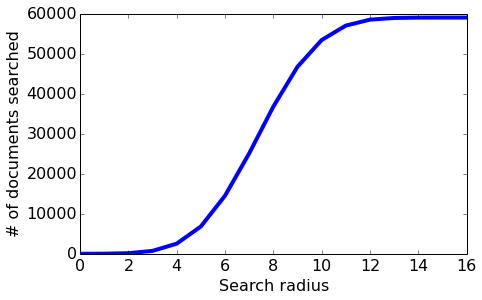

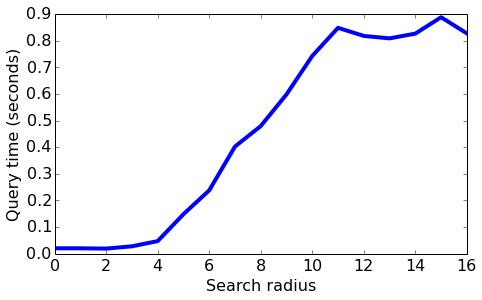

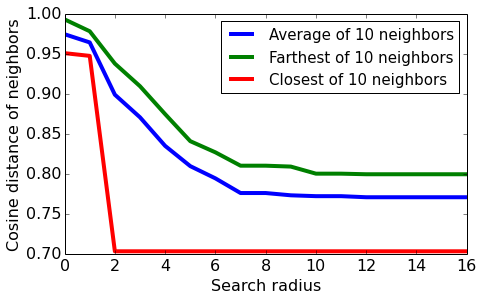

In [86]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Some observations:

- As we increase the search radius, we find more neighbors that are a smaller distance away.
- With increased search radius comes a greater number documents that have to be searched. Query time is higher as a consequence.
- With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

### Quiz Question. What was the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden?

### Quiz Question. Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better?

In [91]:
for i, v in enumerate(average_distance_from_query_history):
    if v <= 0.78:
        print i

7
8
9
10
11
12
13
14
15
16


## Quality metrics for neighbors

The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.
For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:
- Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
- Average cosine distance of the neighbors from the query
Then we run LSH multiple times with different search radii.

In [94]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = sframe.SFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True)

The following cell will run LSH with multiple search radii and compute the quality metrics for each run. Allow a few minutes to complete.

In [95]:
max_radius = 17
precision = {i:[] for i in xrange(max_radius)}
average_distance  = {i:[] for i in xrange(max_radius)}
query_time  = {i:[] for i in xrange(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in xrange(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


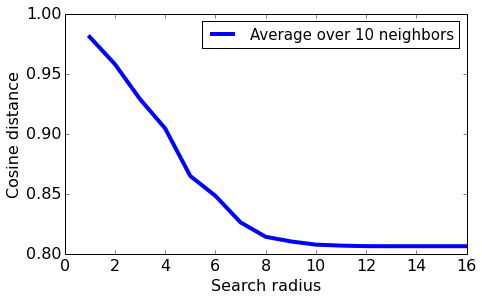

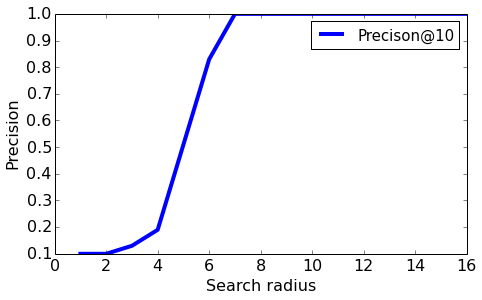

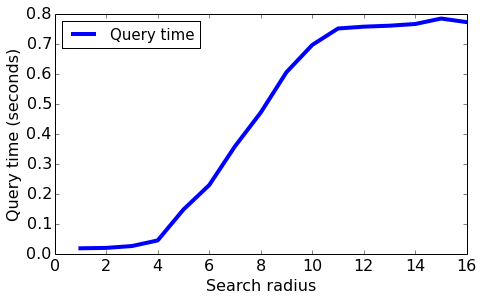

In [96]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in xrange(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in xrange(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in xrange(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Effect of number of random vectors

Let us now turn our focus to the remaining parameter: the number of random vectors. We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.

Allow a few minutes for the following cell to complete.

In [97]:
precision = {i:[] for i in xrange(5,20)}
average_distance  = {i:[] for i in xrange(5,20)}
query_time = {i:[] for i in xrange(5,20)}
num_candidates_history = {i:[] for i in xrange(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in xrange(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


Plot the metrics as a function of the number of random rectors using the following piece of code :

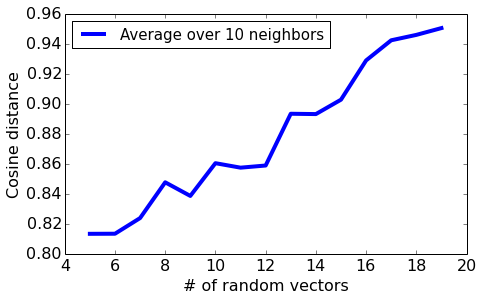

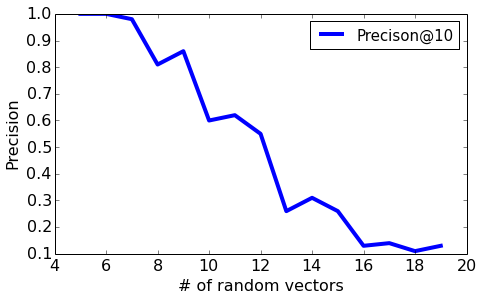

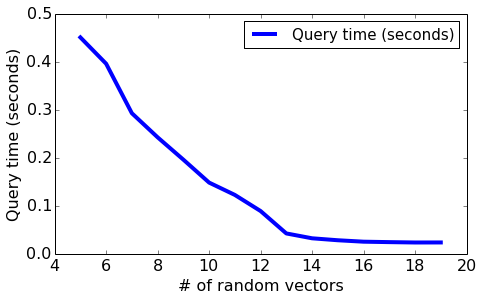

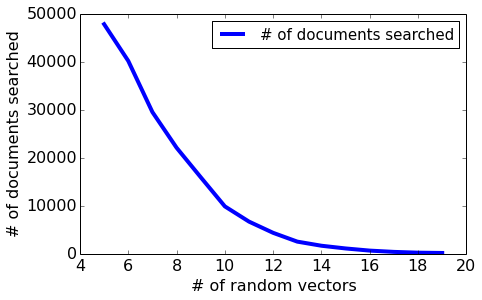

In [98]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in xrange(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in xrange(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in xrange(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in xrange(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

We see a similar trade-off between quality and performance: as the number of random vectors increases, the query time goes down as each bin contains fewer documents on average, but on average the neighbors are likewise placed farther from the query. On the other hand, when using a small enough number of random vectors, LSH becomes very similar brute-force search: Many documents appear in a single bin, so searching the query bin alone covers a lot of the corpus; then, including neighboring bins might result in searching all documents, just as in the brute-force approach.